In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import time
import copy
import sys
import pickle
import numpy as np

with torch.no_grad():
  torch.cuda.empty_cache()

In [19]:
# Use CUDA
if torch.cuda.is_available(): 
 device = 'cuda:0' 
else: 
 device = 'cpu'
print('[INFO] Use ' + str(device))

[INFO] Use cuda:0


In [3]:
from pycocotools import mask as maskUtils
import multiprocessing

path2data="carla_dataset/2023_01_20_15_55/images/"
path2json="carla_dataset/2023_01_20_15_55/annotations/annotation.json"

  
def collate_fn(batch):
    return tuple(zip(*batch))
  
class COCOBoundingBox:
    def __init__(self) -> None:
        pass

    def __call__(self, annotations):
        x, y = annotations[0]['segmentation']['size']
        masks = np.zeros((len(annotations), x, y))
        boxes = np.zeros((len(annotations), 4))
        
        for i, ann in enumerate(annotations):
            masks[i,:,:] = maskUtils.decode(ann['segmentation'])
            
            xmin = ann['bbox'][0]
            ymin = ann['bbox'][1]
            xmax = xmin + ann['bbox'][2]
            ymax = ymin + ann['bbox'][3]
            boxes[i,:] = np.array([xmin, ymin, xmax, ymax])
            
        
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        boxes = torch.as_tensor(boxes, dtype=torch.int64)

        labels = torch.ones((len(annotations),), dtype=torch.int64)
        img_id = torch.tensor([int(ann['image_id']) for ann in annotations], dtype=torch.int64)
        areas = torch.as_tensor([int(ann['area']) for ann in annotations], dtype=torch.float32)
        iscrowd = torch.as_tensor([int(ann['iscrowd']) for ann in annotations], dtype=torch.float32)
        
        # target in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = img_id
        target["area"] = areas
        target["iscrowd"] = iscrowd
        return target

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"



trans = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float32)
])

coco_full_dataset = datasets.CocoDetection(root = path2data,
                                annFile = path2json,
                                transform=trans,
                                target_transform=COCOBoundingBox())


train_size = int(0.2 * len(coco_full_dataset))
test_size = len(coco_full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(coco_full_dataset, [train_size, test_size])

train_size = int(0.5 * len(test_dataset))
test_size = len(test_dataset) - train_size
test_dataset, _ = torch.utils.data.random_split(test_dataset, [train_size, test_size])


coco_train_dataloader = DataLoader(train_dataset,
                                   batch_size=1,
                                   shuffle=True,
                                   num_workers=multiprocessing.cpu_count(),
                                   collate_fn=collate_fn)

coco_test_dataloader =  DataLoader(test_dataset,
                                   batch_size=1,
                                   shuffle=True,
                                   num_workers=multiprocessing.cpu_count(),
                                   collate_fn=collate_fn)


dataloaders = {'train': coco_train_dataloader,
               'test': coco_test_dataloader}

dataset_sizes = {'train': len(train_dataset),
                 'test': len(test_dataset)}

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [4]:
for set in dataset_sizes:
  print(f'{set} set has {dataset_sizes[set]} images.')

train set has 18 images.
test set has 38 images.


In [5]:

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for images, targets in dataloaders['train']:
            images = list(image.to(device) for image in images)
            
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            # if phase == 'train':
            
            # # zero the parameter gradients
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(True):
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                loss_value = losses.item()
                losses.backward()
                optimizer.step()
                scheduler.step()

            # statistics
            running_loss += losses.item()

        epoch_loss = running_loss / dataset_sizes['train']

        print(f'Loss: {epoch_loss:.4f}')

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
import torchvision

fcn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

for param in fcn.parameters():
    param.requires_grad = False

# print('--- ORIGINAL MODEL ---')
# print(fcn)

/home/krzysiek/miniconda3/envs/samochodziki/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/krzysiek/miniconda3/envs/samochodziki/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

in_feats = fcn.roi_heads.box_predictor.cls_score.in_features
fcn.roi_heads.box_predictor = FastRCNNPredictor(in_feats, 4)
print('--- CHANGED MODEL ---')
print(fcn)

--- CHANGED MODEL ---
FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
 

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fcn.parameters(), lr=5e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
num_epochs = 20
save_path = 'model/faster_rcnn.pt'

fcn = fcn.to(device)

model = train_model(
  model=fcn,
  criterion=criterion,
  optimizer=optimizer,
  scheduler=scheduler,
  num_epochs=num_epochs)

torch.save(model, save_path)

Epoch 0/19
----------
Loss: 3.8835

Epoch 1/19
----------
Loss: 3.2797

Epoch 2/19
----------
Loss: 3.2759

Epoch 3/19
----------
Loss: 3.2733

Epoch 4/19
----------
Loss: 3.2828

Epoch 5/19
----------
Loss: 3.2775

Epoch 6/19
----------
Loss: 3.2728

Epoch 7/19
----------
Loss: 3.2770

Epoch 8/19
----------
Loss: 3.2758

Epoch 9/19
----------
Loss: 3.2731

Epoch 10/19
----------
Loss: 3.2797

Epoch 11/19
----------
Loss: 3.2752

Epoch 12/19
----------
Loss: 3.2725

Epoch 13/19
----------
Loss: 3.2742

Epoch 14/19
----------
Loss: 3.2727

Epoch 15/19
----------
Loss: 3.2753

Epoch 16/19
----------
Loss: 3.2720

Epoch 17/19
----------
Loss: 3.2790

Epoch 18/19
----------
Loss: 3.2804

Epoch 19/19
----------
Loss: 3.2772

Training complete in 1m 19s


In [12]:
load_path = 'model/faster_rcnn.pt'
fcn = torch.load(load_path)
fcn.to(device)
fcn.eval()

cpu_device = torch.device("cpu")

for images, targets in dataloaders['test']:
    images = list(img.to(device) for img in images)
    outputs = model(images)
    outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

[{'boxes': tensor([], size=(0, 4), grad_fn=<ToCopyBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<ToCopyBackward0>)}]
[{'boxes': tensor([], size=(0, 4), grad_fn=<ToCopyBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<ToCopyBackward0>)}]
[{'boxes': tensor([], size=(0, 4), grad_fn=<ToCopyBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<ToCopyBackward0>)}]
[{'boxes': tensor([], size=(0, 4), grad_fn=<ToCopyBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<ToCopyBackward0>)}]
[{'boxes': tensor([], size=(0, 4), grad_fn=<ToCopyBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<ToCopyBackward0>)}]
[{'boxes': tensor([], size=(0, 4), grad_fn=<ToCopyBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<ToCopyBackward0>)}]
[{'boxes': tensor([], size=(0, 4), grad_fn=<ToCopyBackward0>), 'labels': ten

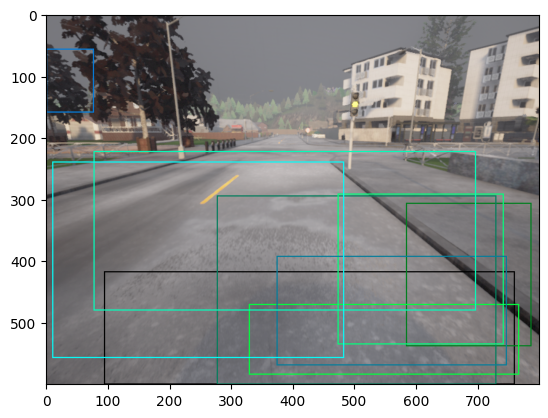

In [129]:
from torchvision.utils import draw_bounding_boxes

load_path = 'model/faster_rcnn.pt'
fcn = torch.load(load_path)
fcn.to(device)
fcn.eval()

cpu_device = torch.device("cpu")

for images, targets in dataloaders['test']:
    images_gpu = list(img.to(device) for img in images)
    outputs = fcn(images_gpu)
    outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
    
    img = (images[0]*255).type(torch.uint8)
    
    outputs[0]['boxes'] = outputs[0]['boxes'][outputs[0]['scores'] > 0.8]

    img = draw_bounding_boxes(img, outputs[0]['boxes'], width=2)
    
    plt.imshow(transforms.ToPILImage()(img))
    break